# LSTM EFAS5: resultados
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 30-09-2023*<br>

**Introducción:**<br>
En este _notebook_ se analizan los resultados del modelo LSTM que replica el caudal simulado en EFAS5 a partir de las series meteorológicas de EMO1 y los atributos estáticos derivados de los mapas estáticos de LISFLOOD y los parámetros calibrados del modelo LISFLOOD.

**Por hacer**:
* [ ] Generar hidrogramas.

In [1]:
import os
ruta_base = os.getcwd()
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from neuralhydrology.utils.config import Config
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
import yaml

os.chdir('../')
from model_utils import *
os.chdir('../1_Pretratamiento/')
from metricas_rendimiento import KGE, KGEmod, ECDF
from plot import rendimiento_LSTM
os.chdir(ruta_base)

In [2]:
# Set the default text font size
plt.rc('font', size=13)
# Set the axes title font size
plt.rc('axes', titlesize=14)
# Set the axes labels font size
plt.rc('axes', labelsize=13)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=12)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=12)
# Set the legend font size
plt.rc('legend', fontsize=12)
# Set the font size of the figure title
plt.rc('figure', titlesize=15)

plt.rcParams['font.family'] = 'Palatino Linotype'

## Configuración

In [3]:
# rutas de entrada y salida de datos
path_data = Path('../../../data/')
path_anuario = path_data / 'anuario_aforos'
path_camels = path_data / 'CAMELS-ES'

In [4]:
# definir simulación
run = 'EFAS_test3_2609_093820' # 'EFAS_test3_1809_163939'

## Datos
### Capas GIS

#### Demarcaciones hidrográficas

In [5]:
demarcaciones = gpd.read_file(path_data / 'cartografia/hidrografia/demarcaciones.shp')
mask = demarcaciones.NOM_DEMAR.isin(['CANTABRICO ORIENTAL', 'CANTABRICO OCCIDENTAL', 'DUERO', 'EBRO', 'GALICIA-COSTA',
                                     'GUADALQUIVIR', 'GUADIANA', 'JUCAR', 'MIÑO-SIL', 'SEGURA', 'TAJO'])
demarcaciones = demarcaciones[mask]

#### Estaciones

In [6]:
# cargar estaciones
estaciones = gpd.read_file(path_anuario / 'GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)
estaciones = estaciones.loc[estaciones.sel == 1]
# estaciones.index = estaciones.index.astype(int)

# definir qué estaciones se usan en el entrenamiento, validación y test
for period in ['train', 'validation', 'test']:
    sample = pd.read_csv(path_camels / f'basins_{period}.txt', header=None).squeeze().values.astype(str)
    estaciones[period] = 0
    estaciones.loc[sample, period] = 1

print(f'nº de estaciones:\t{estaciones.shape[0]}')
# estaciones.head()

nº de estaciones:	269


#### Subcuencas

In [7]:
# cargar polígonos de las cuencas de Caravan
cuencas = gpd.read_file(path_camels / 'shapefiles/catchments_camelses.shp')
cuencas.set_index('gauge_id', drop=True, inplace=True)

n_cuencas = cuencas.shape[0]
print('nº de cuencas en la capa de polígonos:\t{0}'.format(n_cuencas))

nº de cuencas en la capa de polígonos:	269


### Modelo LSTM

In [8]:
# directorio con el modelo
run_dir = Path(f'runs/{run}')

In [9]:
# leer archivo de configuración
cfg = Config(run_dir / 'config.yml')
epochs = cfg.epochs
metric = cfg.metrics[0]
target = cfg.target_variables[0]

In [10]:
# extraer el rendimiento de cada época y muestra
metrics = {period: pd.DataFrame(columns=range(1, epochs + 1)) for period in ['train', 'validation', 'test']}
for period, df in tqdm(metrics.items()):
    for epoch in tqdm(df.columns):
        try:
            _, df[epoch] = get_results(run_dir, period, epoch=epoch)
            # # extraer series temporales
            # for id, dct in ts_period.items():
            #     for x in ['obs', 'sim']:
            #         ts = dct['1D']['xr'][f'{target}_{x}'].sel(time_step=0).to_pandas()
            #         ts.name = id
            #         timeseries[x] = pd.concat((timeseries[x], ts), axis=1)
        except:
            continue

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

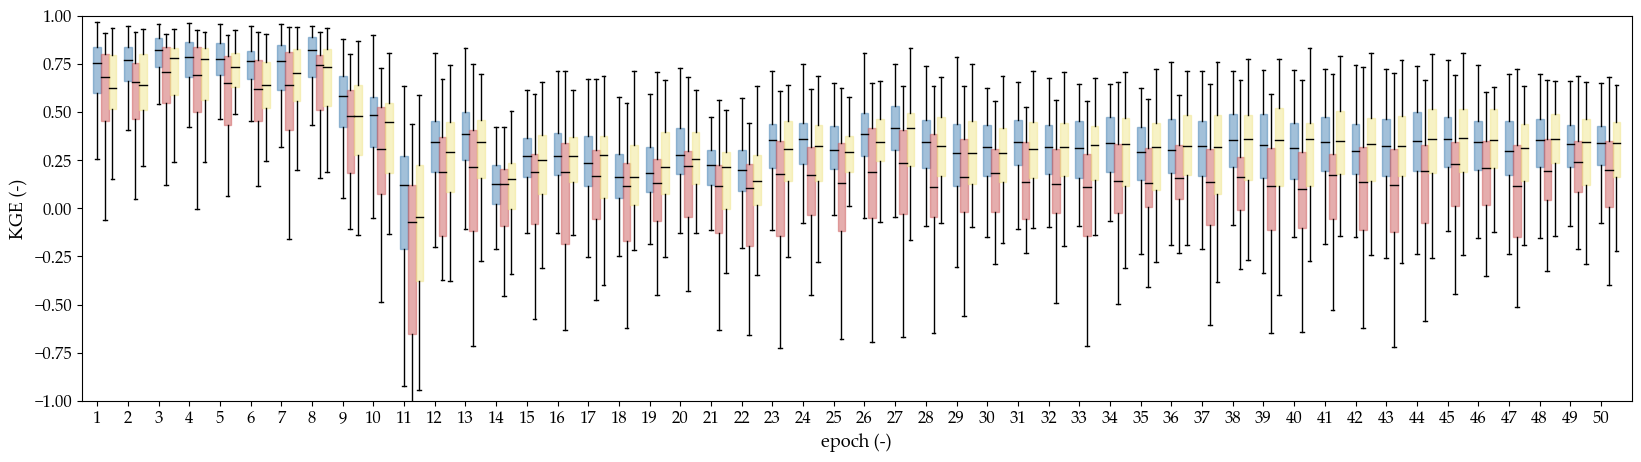

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))

colors = ['steelblue', 'indianred', 'khaki']
for i, ((period, df), c) in enumerate(zip(metrics.items(), colors)):
    bp = ax.boxplot(df, positions=df.columns + i * .25, widths=0.25,
                    patch_artist=True,
                    boxprops={'color': c, 'alpha': .5},
                    # whiskerprops={},
                    showfliers=False,
                    medianprops={'color': 'k'})
    for box in bp['boxes']:
        box.set_facecolor(c)

ax.set_ylim(-1, 1);
xticks = np.linspace(1, epochs, num=epochs).astype(int)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set(xlabel='epoch (-)',
       ylabel=f'{metric} (-)');

plt.savefig(run_dir / 'evolucion_KGE.jpg', dpi=300, bbox_inches='tight')

***Figura 1**. Evolución del rendimento en las muestra de entrenamiento (azul), validación (rojo) y evaluación (amarillo) en cada época.*

In [12]:
# mejor época de cada muestra y el rendimiento de cada muestra en esa época
best_epoch = {}
for period, df in metrics.items():
    epoch = df.median().idxmax()
    best_epoch[period] = epoch
    print('epoch {0:>2}:\tKGEtrain = {1:.3f}   KGEval = {2:.3f}   KGEtest = {3:.3f}'.format(epoch,
                                                                                         metrics['train'][epoch].median(),
                                                                                         metrics['validation'][epoch].median(),
                                                                                         metrics['test'][epoch].median()))

epoch  3:	KGEtrain = 0.822   KGEval = 0.707   KGEtest = 0.784
epoch  8:	KGEtrain = 0.820   KGEval = 0.745   KGEtest = 0.732
epoch  3:	KGEtrain = 0.822   KGEval = 0.707   KGEtest = 0.784


In [13]:
# fig, ax = plt.subplots(figsize=(20, 5))

# colors = ['steelblue', 'indianred', 'k']
# for (period, df), c in zip(metrics.items(), colors):
#     aux = df.quantile([.25, .5, .75])
#     ax.plot(aux.loc[.5], c=c, lw=1, label=period)
#     ax.axvline(best_epoch[period], lw=1, ls='--', c=c)
#     ax.fill_between(aux.columns, aux.loc[.25], aux.loc[.75], color=c, alpha=.1)
# ax.set(xlabel='epoch',
#        xlim=(1 - .2, epochs + .2),
#        ylabel='KGE (-)',
#        ylim=(-1.02, 1.02));
# fig.legend(frameon=False, loc=8, ncol=3, bbox_to_anchor=[.3, -0.05, .4, .05]);

In [14]:
# extraer KGE de la mejor época
epoch = best_epoch['validation']
kge = pd.concat((metrics['train'][epoch], metrics['validation'][epoch], metrics['test'][epoch]), axis=0)
kge.name = 'KGE'
kge.index = kge.index.astype(str)

In [15]:
# añadir rendimiento en el shapefile de estaciones
estaciones = estaciones.loc[kge.index]
estaciones['KGE'] = kge

# export shapefile
estaciones.to_file(run_dir / 'estaciones_KGE.shp', index=True)

# función de densidad empírica de cada muestra
ecdf = {}
for period in ['train', 'validation', 'test']:
    mask = estaciones[period] == 1
    ecdf[period] = ECDF(estaciones[mask].KGE, plot=False)

In [16]:
# añadir rendimiento al shapfile de subcuencas
cuencas['KGE'] = kge.loc[cuencas.index]

# export shapefile
cuencas.to_file(run_dir / 'cuencas_KGE.shp', index=True)

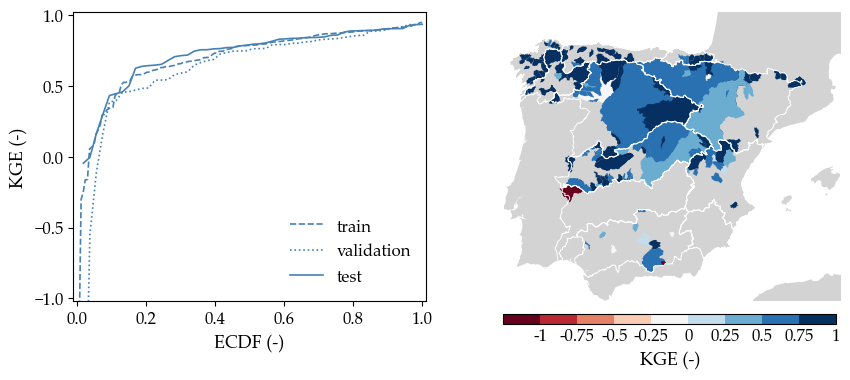

In [17]:
# figura con el rendimiento
rendimiento_LSTM(cuencas, ecdf, 'KGE', demarcaciones, save=run_dir / 'rendimiento.jpg')

In [18]:
# # rendimiento vs área de cuenca
# plt.scatter(cuencas.area_skm, cuencas.KGE, c='steelblue', alpha=.5, s=5);